Соберем это все в свёрточную сеть

Теперь мы готовы собрать нашу первую свеёрточную сеть. 

Для примера рассмотрим архитектуру LeNet, придуманную 1998 году. Она применялась для задачи MNIST — задачи распознавания рукописных цифр.

На вход принималась чёрно-белая картинка размера 32 × 32 × 1. Сначала предлагается применить свёртку с фильтром размером 5 × 5 и обучить 6 таких фильтров, чтобы на выходе получить объем 28 × 28 × 6 (32 превратилось в 28 потому, что мы не использовали padding). Дальше предлагается использовать пулинг слой, чтобы уменьшить картинку в 2 раза, т.о. получив размеры 14 × 14 × 6.

https://lms-cdn.skillfactory.ru/assets/courseware/v1/1a51603a2c5e47854ae3a019208bae54/asset-v1:SkillFactory+MLDL+ALWAYS+type@asset+block/m3sl36.png

Количество фильтров при этом не поменяется, т.к. пулинг работает с каждым feature map независимо.

Потом применяем ещё один свёрточный слой с фильтром 5 × 5, чтобы увеличить поле обзора, и получаем размеры 10 × 10 × 16. Фильтров, которые обучаются, становится уже больше. Это делается для того, чтобы не терять информацию. 

Вновь используем пулинг слой, который сделает нашу картинку размером 5 × 5 × 16. Полученный объём предлагается вытянуть в вектор и к этому вектору применить 2 полносвязных слоя, т.е. предполагается, что в этом последнем пулинг слое в 16 признаках уже закодирована нужная информация, которая поможет нам воссоздать цифру.

После применения двух полносвязных слоёв нужен выходной слой, на котором будет 10 выходов, т.к. у нас 10 цифр, и будет применена функция softmax, которая превратит любые выходы в правильное распределение вероятностей. 

Если взять 60 000 примеров, где у нас есть картинка на входе и для неё известен класс, собрать эту архитектуру и оставить backpropagation на пару минут, то он выучит все веса на всех слоях, которые решают эту задачу практически идеально.

Как работает функция softmax?

Допустим, мы посчитали 10 выходов. Каждый из них заменим на экспоненту в степени этого выхода и пронормируем все полученные экспоненты, чтобы в сумме они давали 1. Т.к. экспонента неотрицательна, а их сумма равна 1, то получим правильное распределение вероятностей.

https://lms-cdn.skillfactory.ru/assets/courseware/v1/630df4984c912617e14901c73ad1b8f2/asset-v1:SkillFactory+MLDL+ALWAYS+type@asset+block/m3sl37.png

Кросс-энтропия

Чтобы запустить backpropagation, нужно знать какую функцию потерь использовать. Для классификации на K классов обычно используют функцию потерь, которую называют кросс-энтропия (cross-entropy).

Для каждого примера мы идем по всем возможным классам и, если пример принадлежит этому классу, то мы в потери записываем логарифм со знаком «минус» от предсказанной вероятности этого класса.

https://lms-cdn.skillfactory.ru/assets/courseware/v1/d7c1e1cd2c30e7f8b4ba23e0323db679/asset-v1:SkillFactory+MLDL+ALWAYS+type@asset+block/m3sl38.png

По графику функции -ln(х) видно, что если аргумент этой функции близок к 1, то потери близки к 0, а если аргумент близок к 0, то потери уходят в бесконечность. Это означает, что в потерях на правильном классе хочется видеть вероятность как можно более близкую к 1. Это и будет решать нашу задачу  классификации.

Если обучить нашу нейросеть и посмотреть на каждом слое изображения, на какие кусочки реагируют (имеют большую активацию) наши нейроны, то заметим, что на первом слое нейроны реагируют на простые паттерны на изображении (например, они могут находить перепады яркости под разными углами). Второй свёрточный слой уже может распознавать что-то более сложное (например, кусочек глаза) и т.д. Таким образом. нейросеть учит иерархические шаблоны.

https://lms-cdn.skillfactory.ru/assets/courseware/v1/e231859d182ac7c08b0db1f905809ca2/asset-v1:SkillFactory+MLDL+ALWAYS+type@asset+block/m3sl39.png

In [3]:
pip install scikit-learn


  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 6.8 MB/s eta 0:00:00 0:00:01

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow as tf
print("We're using TF", tf.__version__)
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import pandas as pd

We're using TF 2.16.2


In [6]:
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 4us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [7]:
print(x_train.shape)
print(x_val.shape)
print (y_train[:10])
print (y_val[:10])

(60000, 28, 28)
(10000, 28, 28)
[9 0 0 3 0 2 7 2 5 5]
[9 2 1 1 6 1 4 6 5 7]


Пример кусочка картинки:


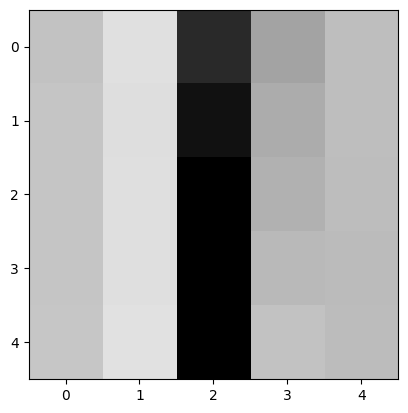

Пример картинки:


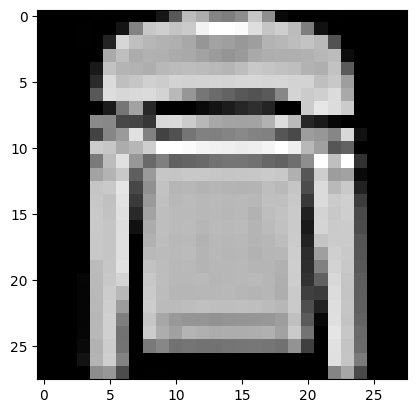

y_train [shape (60000,)] 10 примеров:
 [9 0 0 3 0 2 7 2 5 5]


In [8]:
x_train_image = np.tile(x_train[5, :, :].reshape((28, 28))[:, :, np.newaxis], (1, 1, 3))
print("Пример кусочка картинки:")
plt.imshow(x_train_image[15:20, 5:10], cmap="Greys")
plt.show()
print("Пример картинки:")
plt.imshow(x_train_image, cmap="Greys")
plt.show()
print("y_train [shape %s] 10 примеров:\n" % (str(y_train.shape)), y_train[:10])

In [9]:
# one-hot encode для ответов
y_train_oh = keras.utils.to_categorical(y_train, 10)
y_val_oh = keras.utils.to_categorical(y_val, 10)

print(y_train_oh.shape)
print(y_train_oh[:5], y_train[:5])

(60000, 10)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]] [9 0 0 3 0]


In [10]:
K.clear_session()

# в этот раз используем картинку как вход без вытягивания в вектор!

model = M.Sequential()
model.add(L.Conv2D(16, kernel_size=3, strides=1, padding='same', input_shape=(28, 28, 1)))
model.add(L.MaxPool2D())
model.add(L.Conv2D(32, kernel_size=3, strides=1, padding='same'))
model.add(L.MaxPool2D())
model.add(L.Conv2D(64, kernel_size=3, strides=1, padding='same'))
model.add(L.MaxPool2D())
model.add(L.Flatten())
model.add(L.Dense(10, activation='softmax'))

/Users/apple/python/SkillFactory/Ml_learning/venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-02-10 23:53:08.422502: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-02-10 23:53:08.422536: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-02-10 23:53:08.422543: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-02-10 23:53:08.422734: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-02-10 23:53:08.422747: I tensorflow/core/common_runtime/pluggable_device/plu

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         5,770 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,066 (113.54 KB)

 Trainable params: 29,066 (113.54 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.compile(
    loss='categorical_crossentropy',  # минимизируем кросс-энтропию
    optimizer='adam',  # так будет быстрее, позже узнаем что это :)
    metrics=['accuracy']  # выводим процент правильных ответов
)

In [13]:
# центрируем и нормируем, так сети будет проще учиться (позже узнаем почему :)
x_train_float = x_train.astype(float) / 255 - 0.5
x_val_float = x_val.astype(float) / 255 - 0.5

In [14]:
model.fit(
    x_train_float[:, :, :, np.newaxis],
    y_train_oh,
    batch_size=32,
    epochs=5,
    validation_data=(x_val_float[:, :, :, np.newaxis], y_val_oh)
)

Epoch 1/5


2025-02-10 23:53:53.590064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.7722 - loss: 0.6431 - val_accuracy: 0.8746 - val_loss: 0.3577
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.8831 - loss: 0.3290 - val_accuracy: 0.8864 - val_loss: 0.3301
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.9002 - loss: 0.2786 - val_accuracy: 0.8955 - val_loss: 0.3001
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.9129 - loss: 0.2435 - val_accuracy: 0.8930 - val_loss: 0.2979
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.9210 - loss: 0.2186 - val_accuracy: 0.8997 - val_loss: 0.2802
